In [270]:
import qiskit
import qiskit_machine_learning as qml
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA, SNOBFIT
from qiskit.circuit import Parameter, ParameterExpression, ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels.parameterized_quantum_kernel import ParamQuantumKernel
from qiskit_machine_learning.kernels import QuantumKernel

from qiskit_machine_learning.algorithms import QSVC
from qiskit.aqua.operators import StateFn, Z, ListOp


from qiskit import QuantumCircuit, Aer
from qiskit.aqua import QuantumInstance

import matplotlib.pyplot as plt
import matplotlib.colors as cm
%matplotlib inline

from functools import partial,reduce
import numpy as np
import copy
from copy import deepcopy as dc

# Define a Toy Parameterized Feature Map
### Note that we sandwich the ZZ Feature Map $U({x})$ around our tunable element $W(\theta)$. 
### Our resulting parameterized feature map is then: 
### $$\Phi_\theta(x) = U({x})W(\theta)U({x})$$

### The reason for repeating $U({x})$, is because a feature map of the form:
### $$\tilde\Phi_\theta(x) = W(\theta)U({x})$$
### Will result in a kernel function:
### $$K_{ij} = \left|\langle0\vert\tilde\Phi_\theta(x_i)^\dagger \tilde\Phi_\theta(x_j)\vert0\rangle\right|^2$$
### $$= \left|\langle0\vert U({x_i})^\dagger W(\theta)^\dagger W(\theta) U({x_j})\vert0\rangle\right|^2$$
### $$= \left|\langle0\vert U({x_i})^\dagger  U({x_j})\vert0\rangle\right|^2$$
### Thus the free parameters, $\theta$ would have no effect. 

### The reason for repeating $U({x})$, is because a feature map of the form:
### $$\tilde\Phi_\theta(x) = U({x})W(\theta)$$

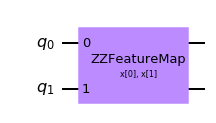

In [385]:
# Define a (non-parameterized) feature map
fm = ZZFeatureMap(2)
input_params = fm.parameters
fm.draw('mpl')

In [386]:
# Define a tunable sub-circuit
W = QuantumCircuit(2)
free_params = ParameterVector('θ', 2)
W.barrier()
W.rx(free_params[0], 1)
W.h(1)
W.crx(free_params[1], 1, 0)
W.barrier()

W = ZZFeatureMap(2, )
free_params = W.parameters
for i in range(len(free_params)):
    free_params[i]._name = 'θ[{}]'.format(i)

# Compose them to build a parameterized feature map
pfm = fm.compose(W).compose(fm)#.decompose()
pfm.draw(output='mpl')

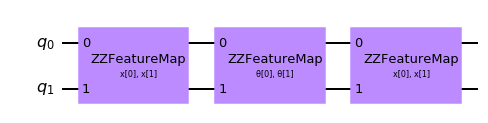

# Build an Ad-hoc dataset

In [389]:
# N = # of data points
N = 20
# d = # dimension of data
d = 2

true_free_vals = [0.4, 1.9]
true_free_bindings = {p:v for (p,v) in zip(free_params, true_free_vals)}

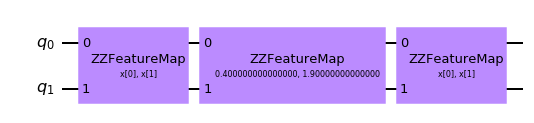

In [408]:
# fm is no longer parameterized, because we have bound values to the free parameters
fm = pfm.bind_parameters(true_free_bindings)
fm.draw('mpl')

In [409]:
# This expression is basically just encoding that after I prepare my feature state
# I want to measure the Pauli Z observable on both qubits. 
fm_op = ~StateFn(Z^Z) @ StateFn(fm) 

# This operator will generate a number between [-1,+1] for each entry in X.
# It is essentially looping over X, binding each datapoint in X to the 
# input parameters of our feature map. It is doing this once for each
# entry of X. So we end up with len(X) copies of our feature map, all with different
# inputs bound to them. We take the expectation of the observable ZZ for each circuit.
y_op = ListOp([fm_op.bind_parameters({p:v for (p,v) in zip(input_params, xi)}) for xi in X])

In [410]:
# Sample data points, reject all xi whose |yi_proba| < w
w = 0.1
d = 2
X = []
y = []
while len(X) < N:
    xi = np.random.rand(d)
    yi = fm_op.bind_parameters({p:v for (p,v) in zip(input_params, xi)}).eval()
    if np.abs(yi) >= w:
        X.append(xi)
        y.append(yi)

In [412]:
# These expectation values are always real numbers, and we only really care
# about taking their sign.
y_proba = np.real(y_op.eval())
y  = np.sign(y_proba)
print(y_proba)
print(y)

[-0.2960487  -0.51667797 -0.25808805 -0.44719098 -0.27240402 -0.31966421
 -0.47277547 -0.4730628  -0.38758979 -0.28136415 -0.48539092  0.73082185
 -0.50302575 -0.37569855 -0.31115861 -0.58793845  0.64237895  0.34698463
 -0.35110689 -0.48881265]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.  1.  1.
 -1. -1.]


In [413]:
print('X = np.array({})'.format(np.array(X).tolist()))
print('y = np.array({})'.format(y.tolist()))

X = np.array([[0.9567612067697236, 0.29073480898094595], [0.5346295164276453, 0.28314590337282675], [0.4505164537165349, 0.1348844084345856], [0.717095964284348, 0.6926539694817647], [0.6899904242073004, 0.11894254875732169], [0.9331929543471993, 0.1710356466941273], [0.9465065903873696, 0.08866785584134762], [0.020821616675430255, 0.795816864607097], [0.11396873060321688, 0.597495651509774], [0.43382947964712637, 0.015927416849493836], [0.9442809322211615, 0.9895496473858371], [0.04664013387835264, 0.2098641515156191], [0.8170482966873857, 0.12136924758892997], [0.8674239716401573, 0.9695260771109943], [0.7819845649388245, 0.36615922941017176], [0.2616107759284595, 0.7224424998541275], [0.9370643995995782, 0.6308179906118104], [0.5942319745353428, 0.6530442138654083], [0.699064828319063, 0.5601537947326779], [0.0705901741870586, 0.2036948590213834]])
y = np.array([-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0])


In [348]:
# w = 0
X = np.array([[0.8706654792362811, 0.2369742757376293], [0.5236444947461981, 0.47706078258840867], [0.32718563532890166, 0.5115873322128263], [0.43386908952550884, 0.7268119714452476], [0.5959016911155639, 0.34661481471692046], [0.7064915357994602, 0.04683842708096886], [0.8720288508400597, 0.3391179272755003], [0.20969548243722935, 0.6526412363347083], [0.30453891143802225, 0.6869816088228596], [0.06393682681335267, 0.6539151117867389], [0.33144917572376775, 0.6628320750526255], [0.377667541739669, 0.7398903275013423], [0.3238996455451548, 0.6980217247056245], [0.21252022637269152, 0.9156762288662499], [0.784072270815886, 0.56597118587358], [0.5162437571367566, 0.10036739611370471], [0.38034726220142634, 0.977044551667746], [0.3747999018613254, 0.3651309902912411], [0.06572618538859043, 0.9757767726065338], [0.8176978256864683, 0.8992809375698265]])
y = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0])

In [345]:
# w = .5
X = np.array([[0.24454073410898491, 0.031012938811814772], [0.15729723854472633, 0.7771822300844446], [0.7108284468216548, 0.1894054901931822], [0.22150210121369418, 0.005694881230791093], [0.22271372771505904, 0.8015695630814424], [0.20765557949660574, 0.39924467912560047], [0.4527791328642101, 0.2443531076263249], [0.9491652757796688, 0.03879299346053222], [0.13651516478509684, 0.6818473574803955], [0.03923793993639102, 0.25349832871562294], [0.3036545701526323, 0.2504910407578973], [0.20298849297019894, 0.40999257495837094], [0.689720552907621, 0.3006912349622771], [0.09872532648444432, 0.08452522097652959], [0.0018661159252205684, 0.21701814845269307], [0.07209175613676211, 0.8825548774902298], [0.006499324077934632, 0.5067728182164672], [0.425773895955486, 0.1275224534379158], [0.15774990481285356, 0.4685387613882338], [0.17021331958034303, 0.6604169564060065]])
y = np.array([1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0])

In [344]:
# w = 0.1
X =  np.array([[0.08014620505503967, 0.8585289757019198], [0.2363859777964431, 0.9792415062429451], [0.5694036596253715, 0.2525712802791743], [0.5309968914272779, 0.45689713345718896], [0.542831682256627, 0.17117097892232447], [0.2437724067302578, 0.11058803430940511], [0.0934309591004342, 0.40063349207062826], [0.3106335355747758, 0.3969438519287384], [0.15666090561250445, 0.45921694133943514], [0.48251827558346927, 0.04203592199854633], [0.38830659794189404, 0.8445200143015964], [0.34375280035518097, 0.5685127816492518], [0.5886362555749514, 0.0633603070349168], [0.8569637156127624, 0.4180126850971225], [0.3192345186587584, 0.446325031456702], [0.5135014414458929, 0.18310641325643873], [0.18928181633716556, 0.5964832616172795], [0.21260141055336135, 0.8561363327817257], [0.117883298272771, 0.7355136697612326], [0.8923063407096165, 0.9649830130743133]])
y =  np.array([1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0])
